In [143]:
# Import dependencies
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy.ext.automap import automap_base

from sqlalchemy import Column, Integer, String, Float, Date, desc, func, and_

In [144]:
# Use create the engine and assign classes
engine = create_engine("sqlite:///hawaii.sqlite")

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

Station = Base.classes.Stations
Measurement = Base.classes.Measurements

session = Session(engine)

# Precipitation Analysis

In [145]:
# Define vacation period
vacation_strat_date = dt.date.today()
vacation_end_date = vacation_strat_date + dt.timedelta(days=7)

In [146]:
# Select only the date and prcp values.
a_year_ago = vacation_end_date - dt.timedelta(days=365)
prcp_ds = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year_dt).all()

In [147]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
prcp_df = pd.DataFrame(prcp_ds, columns=["date", "precipitation"])

# Change the date to a datetime format.
prcp_df['date'] = pd.to_datetime(prcp_df['date'], format='%Y/%m/%d')
prcp_df.head()

,date,precipitation
0,2017-04-28,0.00
1,2017-04-29,0.12
2,2017-04-30,0.89
3,2017-05-01,0.26
4,2017-05-02,0.00


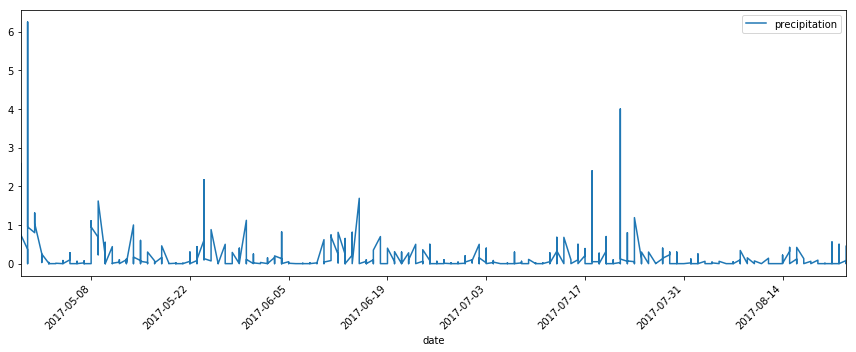

In [148]:
# Plot the results using the DataFrame plot method.
prcp_df.set_index(prcp_df["date"], inplace = True)
prcp_df.plot(figsize=(12,5))
plt.xticks(rotation = '45')
plt.tight_layout()
plt.show()

# Station Analysis

In [149]:
# Design a query to calculate the total number of stations.
num_stations = session.query(Station.station).count()
print("The number of stations is: %s" % num_stations)

The number of stations is: 9


In [150]:
# Design a query to find the most active stations.
## List the stations and observation counts in descending order
## Which station has the highest number of observations?
act_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(desc(func.count(Measurement.date))).all()

most_active = act_stations[0][0]
num_observations = act_stations[0][1]

print("The most active station is: %s" % most_active)
print("Number of observations for station %s: %s" % (most_active, num_observations))

The most active station is: USC00519281
Number of observations for station USC00519281: 2772


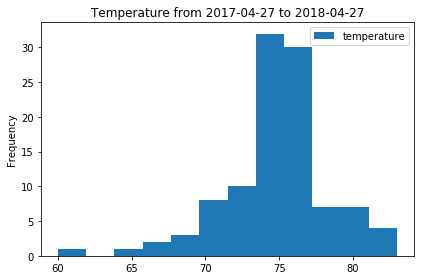

In [151]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
## Filter by the station with the highest number of observations.
temp_year = session.query(Measurement.date, Measurement.tobs).filter(and_(Measurement.date <= vacation_end_date,
                                                                        Measurement.date >= a_year_ago,
                                                                         Measurement.station == most_active)).all()

# create the dataframe and set date as the index
temp_df = pd.DataFrame(temp_year, columns = ["date", "temperature"])
temp_df.set_index('date', inplace=True)

## Plot the results as a histogram with bins=12.
temp_df.iloc[::-1].plot.hist(title="Temperature from %s to %s" % (a_year_ago, vacation_end_date), bins = 12)
plt.tight_layout()
plt.show()

# Temperature Analysis

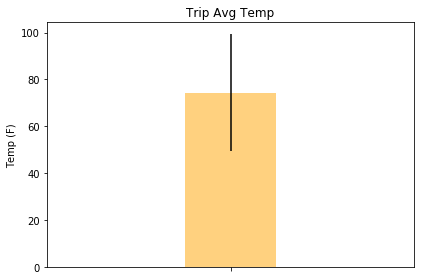

In [152]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start, end):
        start = end - dt.timedelta(365)
# Use the calc_temps function to calculate the min, 
        min_temp = session.query(func.min(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= start)).all()
        minimum = min_temp[0][0]
        # avg 
        avg_temp = session.query(func.avg(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= start)).all()
        average = avg_temp[0][0]
        # and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
        max_temp = session.query(func.max(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= start)).all()
        maximum = max_temp[0][0]
        
        # Plot the min, avg, and max temperature from your previous query as a bar chart.
        ## Use the average temperature as the bar height.
        ## Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
        objects = [str(end)]
        x_axis = np.arange(len(objects))
        fig, ax = plt.subplots()
        temp_plot = ax.bar(x_axis, average, yerr=(maximum-minimum), color = "orange", alpha = .5, width = .5)
        tick_locations = [value for value in x_axis]
        plt.xticks(tick_locations, [])
        plt.xlim(-1, len(x_axis))
        plt.title("Trip Avg Temp")
        plt.ylabel("Temp (F)")
        plt.tight_layout()
        plt.show()
        
# call the function
calc_temps(vacation_strat_date, a_year_ago)

# Optional Recommended Analysis

In [153]:
# Calcualte the rainfall per weather station using the previous year's matching dates.
total_prcp = session.query(Measurement.station, func.sum(Measurement.prcp)).group_by(Measurement.station).all()

total_prcp_df = pd.DataFrame(total_prcp, columns=["Station", "Total Precipitation from %s to %s" % (a_year_ago, vacation_end_date)])
total_prcp_df

,Station,Total Precipitation from 2017-04-27 to 2018-04-27
0,USC00511918,92.68
1,USC00513117,382.62
2,USC00514830,234.49
3,USC00516128,1068.09
4,USC00517948,43.44
5,USC00518838,70.87
6,USC00519281,588.64
7,USC00519397,131.62
8,USC00519523,295.68
